In [1]:
# this model includes ql
# it uses instantaneous bedrock erosion rate to calc ql
# it uses gamma to represent fraction of plucked material that becomes coarse gravel
# it uses theta to represent fraction of hillslope material that enters fluvial system as coarse 
## (maybe this should be same as gamma, 
## since the real fxn of this parameter is to tell us 
## how much coarse stuff is available for bedload transport/abrasion)

# potential updates: see if adding weighted average back in to ql calculation still allows for stability
## update on the update: this led to stability issues, and it's not worth the time now trying to debug, 
## so just stick with using instantaneous erosion rate. 
## Most interested in steady state profiles anyway, so this is fine.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# create a profile
dx = 500
x = np.arange(0, 50000, dx)
x_node = x + (dx/2)

# add some elevation
Hstar = 0.5 # depth decay
etab = np.zeros(len(x)) # bedrock elevation
etab[:] = np.linspace(1, 0.1, len(x)) # need to start with slight bedrock slope
H = Hstar + np.zeros(len(x)) # alluvium thickness
eta = etab + H # topography

In [4]:
# define constants and other parameters
K = 1e-7 # erodibility
beta = 0.0005 # abradability
r = 2.5 # runoff rate
U = 0.0001 # uplift or baselevel fall rate
I = 0.01 # intermittency
phi = 0.1 # porosity
D = 0.01 # grain size
gamma = 0.5 # fraction plucked that becomes coarse
theta = 0.5 # fraction hillslope that enters as coarse
# treat as same!!! Point is what fraction becomes coarse
# so just be sure to change these together

kqs = 0.041 # sed transport coeff
kxb = 25 # valley width coeff
Pxb = 1./5. # valley width exp
kb = 8.3e-8 # channel width coeff

B_valley = kxb * (x_node**Pxb) # valley width
# Q = (r * kxb * x_node**(1 + Pxb))/(1 + Pxb) # discharge
A = (1./3.) * (x**2)
Q = r * A

In [5]:
def model(x, dx, x_node,
          K, beta, gamma, theta,
          D, phi, Hstar,
          kb, kqs, I, r, U,
          etab, H, eta,
          B_valley, Q,
          num_steps = 1):
    
    q = Q/B_valley
    dt = 50
    
    run_duration = dt * num_steps
    cum_time = 0.0
    
    Qs = np.zeros(len(x))
    qs = np.zeros(len(x))
    Eb_p = np.zeros(len(x))
    Eb_a = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    ql = np.zeros(len(x)) # lateral sediment supply
    
    H[-1] = 0
    E[-1] = U
    q[0] = 0
    Qs[0] = 0
    
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= U * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc sed transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1])
        qs[1:] = Qs[1:] / B_valley[1:]
        
        # calc bedrock erosion
        Eb_p[:-1] = K * Q[1:] * S**(7./6.) * alpha[:-1] * gamma
        Eb_a[:-1] = beta * Qs[1:] * alpha[:-1]
        Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B_valley[:-1]
        
        # calc lateral flux
        ql[:-1] = ((Eb[:-1] * theta)/beta) * (1 - np.exp(-beta * x[1:]/3))
        
        # calc grain attrition
        atr = Qs * beta
        
        # calc sediment erosion rate
        Eh[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs)/dx + atr[1:] - Eb_p[:-1] - ql[:-1])
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
        
    print(cum_time)
        
    return (dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta)

In [6]:
#now write a test
num_steps = 5000000

test_run = [x, dx, x_node, 
            K, beta, gamma, theta,
            D, phi, Hstar,
            kb, kqs, I, r, U,
            etab, H, eta,
            B_valley, Q,
            num_steps]

# and run it
(dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta) = model(*test_run)

250000000.0


In [7]:
Eb

array([1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04, 1.e-04,
       1.e-04, 1.e-04, 1.e-04, 0.e+00])

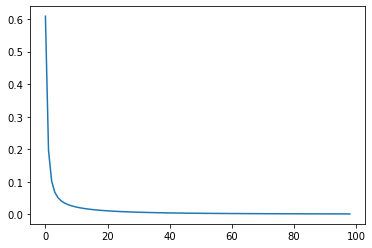

In [8]:
plt.plot(S)

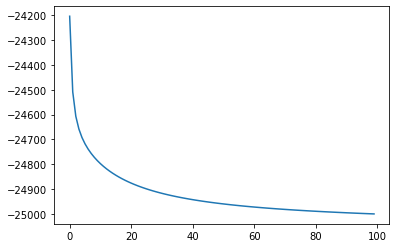

In [9]:
plt.plot(eta)

In [10]:
S[-1]

0.0009509491042699664

In [11]:
eta

array([-24204.1947566 , -24508.61698201, -24606.72594506, -24657.89618228,
       -24691.92742668, -24717.64747521, -24738.50697457, -24756.14818309,
       -24771.47149274, -24785.02466636, -24797.16816784, -24808.15403396,
       -24818.16707844, -24827.34804401, -24835.80741319, -24843.63406971,
       -24850.90096746, -24857.66897979, -24863.98959847, -24869.90687994,
       -24875.4588841 , -24880.67876143, -24885.5955905 , -24890.23503438,
       -24894.6198631 , -24898.77037508, -24902.7047412 , -24906.43928887,
       -24909.98873868, -24913.36640328, -24916.58435587, -24919.65357385,
       -24922.5840621 , -24925.38495935, -24928.06463044, -24930.6307467 ,
       -24933.09035632, -24935.44994608, -24937.71549587, -24939.89252683,
       -24941.98614407, -24944.00107472, -24945.9417018 , -24947.81209456,
       -24949.61603561, -24951.35704539, -24953.03840408, -24954.66317142,
       -24956.2342046 , -24957.75417446, -24959.22558019, -24960.65076259,
       -24962.03191627, -

In [12]:
eta_adj = eta - eta[-1]

In [13]:
eta_adj

array([7.95205244e+02, 4.90783019e+02, 3.92674056e+02, 3.41503818e+02,
       3.07472574e+02, 2.81752525e+02, 2.60893026e+02, 2.43251818e+02,
       2.27928508e+02, 2.14375334e+02, 2.02231833e+02, 1.91245967e+02,
       1.81232922e+02, 1.72051957e+02, 1.63592587e+02, 1.55765931e+02,
       1.48499033e+02, 1.41731021e+02, 1.35410402e+02, 1.29493121e+02,
       1.23941116e+02, 1.18721239e+02, 1.13804410e+02, 1.09164966e+02,
       1.04780137e+02, 1.00629626e+02, 9.66952594e+01, 9.29607117e+01,
       8.94112619e+01, 8.60335973e+01, 8.28156447e+01, 7.97464267e+01,
       7.68159385e+01, 7.40150412e+01, 7.13353702e+01, 6.87692539e+01,
       6.63096443e+01, 6.39500545e+01, 6.16845047e+01, 5.95074738e+01,
       5.74138565e+01, 5.53989259e+01, 5.34582988e+01, 5.15879060e+01,
       4.97839650e+01, 4.80429552e+01, 4.63615965e+01, 4.47368292e+01,
       4.31657960e+01, 4.16458261e+01, 4.01744204e+01, 3.87492380e+01,
       3.73680843e+01, 3.60289000e+01, 3.47297506e+01, 3.34688179e+01,
      